## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# Pretrained weights
# ref - https://github.com/kenshohara/3D-ResNets-PyTorch
!pip install gdown
!gdown 1fFN5J2He6eTqMPRl_M9gFtFfpUmhtQc9

# Utility packages for reading and visualizing volumes
!pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

Downloading...
From (uriginal): https://drive.google.com/uc?id=1fFN5J2He6eTqMPRl_M9gFtFfpUmhtQc9
From (redirected): https://drive.google.com/uc?id=1fFN5J2He6eTqMPRl_M9gFtFfpUmhtQc9&confirm=t&uuid=65cdc518-a35b-45a2-9694-5d7c198196ab
To: /kaggle/working/r3d34_K_200ep.pth
100%|████████████████████████████████████████| 511M/511M [00:05<00:00, 93.2MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 72.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=10f200c101d67ce597459d1d987a32aec51bee126721b1968acbc5e6e31fb0ad
  Stored in directory: /root/.cache/pip/wheels/e2/97/c4/5537ba28215ed3508783dc23c1fb59e17f00722317e4edeac0
Successfully built asciitree


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("/kaggle/input/resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 224
Z_START = 26
Z_DIMS = 12
TRAIN_FRAGMENTS = ["1", "2b", "3"]
TEST_FRAGMENT = "2a"

### Load data

In [4]:
FRAGMENTS_ZARR = {
    "1" : zarr.open("/kaggle/input/vesuvius-zarr-files/train-1.zarr", mode="r"),
    "2" : zarr.open("/kaggle/input/vesuvius-zarr-files/train-2.zarr", mode="r"),
    "3" : zarr.open("/kaggle/input/vesuvius-zarr-files/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

In [6]:
fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
fragment_cropped.shape

(224, 224, 12)

In [7]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]
mask_cropped.shape

(224, 224)

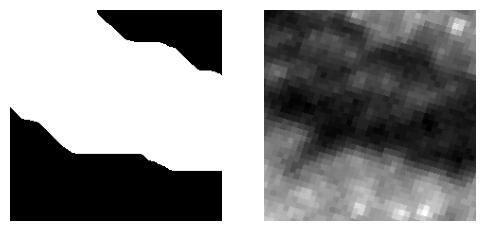

In [8]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [9]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

3955

### Dataloaders

In [10]:
class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            if fragment=='2b':
                fragment = '2'
                H, W = FRAGMENTS_SHAPE[fragment]
                H1 = { #ab split
                    '1': 4560,
                    '2': 9456,
                    '3': 4060,
                }['2']
#                 pad0 = (CROP_SIZE - H % CFG.tile_size)
#                 pad1 = (CROP_SIZE - W % CFG.tile_size)
#                 image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)
                for y in range(H1, H-CROP_SIZE+1, CROP_SIZE):
                    for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                        self.xys.append((fragment, x, y, W, H))
            else:
                H, W = FRAGMENTS_SHAPE[fragment]
                for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                    for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                        self.xys.append((fragment, x, y, W, H))
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-32 if x1 != 0 else 0, 32)
        y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        if random.random() > 0.5:
            frag_crop = np.flip(frag_crop, axis=1).copy()
            mask_crop = np.flip(mask_crop, axis=1).copy()

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [11]:
FRAGMENTS_SHAPE['2']

(14830, 9506)

In [12]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.xys = []
        if fragment=='2a':
            fragment = '2'
            self.fragment = FRAGMENTS_ZARR[fragment]
            _, W = FRAGMENTS_SHAPE[fragment]
            H = { #ab split
                '1': 4560,
                '2': 9456,
                '3': 4060,
            }['2']
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((x, y))
        else:
            self.fragment = FRAGMENTS_ZARR[fragment]
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [13]:
TEST_FRAGMENT

'2a'

In [14]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)      #85
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)  
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False) #56
n_valid = len(dataloader_valid)  

In [15]:
# for batch in dataloader_valid:
#     frag_crop,mask_crop,xys = batch
#     print(len(xys))

In [16]:
# for i in range(len(dataset_valid)):
#     frag_crop,mask_crop,xys = dataset_valid[i]
#     print(frag_crop.shape)

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [17]:
class CFG:
    backbone = 'resnet3d'

In [18]:
def normalization(x):
    """input.shape=(batch,f1,f2,...)"""
    #[batch,f1,f2]->dim[1,2]
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    return (x-mean)/(std+1e-9)
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=34, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        if x.ndim==4:
            x=x[:,None]
            
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))
        
class CustomModel(nn.Module):
    def __init__(self, cfg=CFG, weight=None):
        super().__init__()
        self.cfg = cfg

        if cfg.backbone=="resnet3d":
            self.encoder=SegModel()
        elif cfg.backbone[:3]!="mit":
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                in_channels=cfg.in_chans,
                classes=cfg.target_size,
                activation=None,
            )
        else :
            self.encoder = smp.Unet(
                encoder_name=cfg.backbone, 
                encoder_weights=weight,
                classes=cfg.target_size,
                activation=None,
            )
            print(self.encoder.encoder.patch_embed1.proj)
            out_channels=self.encoder.encoder.patch_embed1.proj.out_channels
            self.encoder.encoder.patch_embed1.proj=nn.Conv2d(cfg.in_chans,out_channels,7,4,3)

    def forward(self, images:torch.Tensor):
        #image.shape=(b,C,H,W)
        if images.ndim==4:
            images=images[:,None]
        images=normalization(images)
        output = self.encoder(images)
        return output

In [19]:
model = CustomModel()
model.encoder.load_pretrained_weights(torch.load("r3d34_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0, 1])
model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


### Competition metric (F0.5 Score)

In [20]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [21]:
# import sys
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')
# import segmentation_models_pytorch as smp
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 25.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=248690415de8463afc4ad7eabfe08ac2581b64622d6bc8fc775d8354f2e425bc
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=e501ee4cc31c9321488020c9e66f101a4da2a76fde7d0ba5cd3acb02184172ba
  Stored in directory: /root/.cache/pip/wheels/4f/89/a3/5cf59e30a8a75c917c313f14da0f6209be2d147e3160b985d6
Successfully built efficientnet-pytorch pretrainedmodels
  Attempting uninstall: timm
    Found existing i

In [22]:
import segmentation_models_pytorch as smp
# from segmentation_models_pytorch.decoders.unet.decoder import UnetDecoder

In [23]:
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
#     return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

In [24]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [25]:
if TEST_FRAGMENT == '2a':
    FRAGMENT='2'
    gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[FRAGMENT].truth)[:9456,:]).float().cuda()
    gt_shape = list(FRAGMENTS_SHAPE[FRAGMENT])
    gt_shape[0] = 9456
    gt_shape = tuple(gt_shape)
else:
    gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
    gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [26]:
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda(), masks.cuda()
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.7, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet34_3d_seg_epoch_{epoch}.pt")

    if epoch == 30:
        break

    print()

Epoch 1/50  Mem : 6.11GB  LR : 4.00E-06  Loss: 0.6864: 100%|██████████| 85/85 [01:48<00:00,  1.27s/it]
Val Loss: 0.6561: 100%|██████████| 56/56 [01:10<00:00,  1.26s/it]


Threshold : 0.20	FBeta : 0.130593
Threshold : 0.25	FBeta : 0.182171
Threshold : 0.30	FBeta : 0.206006
Threshold : 0.35	FBeta : 0.215322
Threshold : 0.40	FBeta : 0.223603
Threshold : 0.45	FBeta : 0.234351
Threshold : 0.50	FBeta : 0.247846
Threshold : 0.55	FBeta : 0.260494
Threshold : 0.60	FBeta : 0.266480
Threshold : 0.65	FBeta : 0.264846



Epoch 2/50  Mem : 8.63GB  LR : 1.81E-05  Loss: 0.6451: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5977: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.183280
Threshold : 0.25	FBeta : 0.216877
Threshold : 0.30	FBeta : 0.225898
Threshold : 0.35	FBeta : 0.241894
Threshold : 0.40	FBeta : 0.263767
Threshold : 0.45	FBeta : 0.284396
Threshold : 0.50	FBeta : 0.294207
Threshold : 0.55	FBeta : 0.293081
Threshold : 0.60	FBeta : 0.283727
Threshold : 0.65	FBeta : 0.262237



Epoch 3/50  Mem : 8.63GB  LR : 5.20E-05  Loss: 0.5903: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it]
Val Loss: 0.6293: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.208512
Threshold : 0.25	FBeta : 0.217979
Threshold : 0.30	FBeta : 0.228433
Threshold : 0.35	FBeta : 0.243478
Threshold : 0.40	FBeta : 0.261087
Threshold : 0.45	FBeta : 0.275643
Threshold : 0.50	FBeta : 0.287559
Threshold : 0.55	FBeta : 0.299979
Threshold : 0.60	FBeta : 0.310684
Threshold : 0.65	FBeta : 0.317780



Epoch 4/50  Mem : 8.63GB  LR : 8.59E-05  Loss: 0.5485: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5335: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.288346
Threshold : 0.25	FBeta : 0.337492
Threshold : 0.30	FBeta : 0.365604
Threshold : 0.35	FBeta : 0.379730
Threshold : 0.40	FBeta : 0.389431
Threshold : 0.45	FBeta : 0.398230
Threshold : 0.50	FBeta : 0.405629
Threshold : 0.55	FBeta : 0.407739
Threshold : 0.60	FBeta : 0.396116
Threshold : 0.65	FBeta : 0.379131



Epoch 5/50  Mem : 8.63GB  LR : 1.00E-04  Loss: 0.5172: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.6208: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.234911
Threshold : 0.25	FBeta : 0.243850
Threshold : 0.30	FBeta : 0.252586
Threshold : 0.35	FBeta : 0.260909
Threshold : 0.40	FBeta : 0.268580
Threshold : 0.45	FBeta : 0.275568
Threshold : 0.50	FBeta : 0.286233
Threshold : 0.55	FBeta : 0.300106
Threshold : 0.60	FBeta : 0.314217
Threshold : 0.65	FBeta : 0.328182



Epoch 6/50  Mem : 8.63GB  LR : 9.99E-05  Loss: 0.4966: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5291: 100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


Threshold : 0.20	FBeta : 0.299953
Threshold : 0.25	FBeta : 0.324913
Threshold : 0.30	FBeta : 0.343941
Threshold : 0.35	FBeta : 0.355452
Threshold : 0.40	FBeta : 0.364103
Threshold : 0.45	FBeta : 0.370657
Threshold : 0.50	FBeta : 0.377203
Threshold : 0.55	FBeta : 0.381296
Threshold : 0.60	FBeta : 0.380930
Threshold : 0.65	FBeta : 0.372682



Epoch 7/50  Mem : 8.63GB  LR : 9.95E-05  Loss: 0.4711: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.7224: 100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


Threshold : 0.20	FBeta : 0.235424
Threshold : 0.25	FBeta : 0.239109
Threshold : 0.30	FBeta : 0.242077
Threshold : 0.35	FBeta : 0.244490
Threshold : 0.40	FBeta : 0.246629
Threshold : 0.45	FBeta : 0.248635
Threshold : 0.50	FBeta : 0.252014
Threshold : 0.55	FBeta : 0.256928
Threshold : 0.60	FBeta : 0.260290
Threshold : 0.65	FBeta : 0.263641



Epoch 8/50  Mem : 8.63GB  LR : 9.89E-05  Loss: 0.4577: 100%|██████████| 85/85 [01:38<00:00,  1.15s/it]
Val Loss: 0.5221: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.440209
Threshold : 0.25	FBeta : 0.442169
Threshold : 0.30	FBeta : 0.436446
Threshold : 0.35	FBeta : 0.429326
Threshold : 0.40	FBeta : 0.420787
Threshold : 0.45	FBeta : 0.411366
Threshold : 0.50	FBeta : 0.400001
Threshold : 0.55	FBeta : 0.384744
Threshold : 0.60	FBeta : 0.363779
Threshold : 0.65	FBeta : 0.338345



Epoch 9/50  Mem : 8.63GB  LR : 9.81E-05  Loss: 0.4349: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.4926: 100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


Threshold : 0.20	FBeta : 0.385699
Threshold : 0.25	FBeta : 0.421698
Threshold : 0.30	FBeta : 0.442712
Threshold : 0.35	FBeta : 0.455348
Threshold : 0.40	FBeta : 0.461831
Threshold : 0.45	FBeta : 0.465575
Threshold : 0.50	FBeta : 0.465130
Threshold : 0.55	FBeta : 0.460538
Threshold : 0.60	FBeta : 0.455267
Threshold : 0.65	FBeta : 0.448834



Epoch 10/50  Mem : 8.63GB  LR : 9.70E-05  Loss: 0.4383: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5682: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.347060
Threshold : 0.25	FBeta : 0.304871
Threshold : 0.30	FBeta : 0.271561
Threshold : 0.35	FBeta : 0.241422
Threshold : 0.40	FBeta : 0.214677
Threshold : 0.45	FBeta : 0.180666
Threshold : 0.50	FBeta : 0.112494
Threshold : 0.55	FBeta : 0.081238
Threshold : 0.60	FBeta : 0.059201
Threshold : 0.65	FBeta : 0.039306



Epoch 11/50  Mem : 8.63GB  LR : 9.57E-05  Loss: 0.4146: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5980: 100%|██████████| 56/56 [01:08<00:00,  1.22s/it]


Threshold : 0.20	FBeta : 0.149032
Threshold : 0.25	FBeta : 0.117206
Threshold : 0.30	FBeta : 0.098600
Threshold : 0.35	FBeta : 0.085479
Threshold : 0.40	FBeta : 0.074690
Threshold : 0.45	FBeta : 0.063165
Threshold : 0.50	FBeta : 0.042475
Threshold : 0.55	FBeta : 0.030800
Threshold : 0.60	FBeta : 0.021919
Threshold : 0.65	FBeta : 0.014566



Epoch 12/50  Mem : 8.63GB  LR : 9.41E-05  Loss: 0.4075: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it]
Val Loss: 0.5201: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.451547
Threshold : 0.25	FBeta : 0.449710
Threshold : 0.30	FBeta : 0.446889
Threshold : 0.35	FBeta : 0.443746
Threshold : 0.40	FBeta : 0.440577
Threshold : 0.45	FBeta : 0.435779
Threshold : 0.50	FBeta : 0.425489
Threshold : 0.55	FBeta : 0.415124
Threshold : 0.60	FBeta : 0.399597
Threshold : 0.65	FBeta : 0.378245



Epoch 13/50  Mem : 8.63GB  LR : 9.24E-05  Loss: 0.3902: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5250: 100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


Threshold : 0.20	FBeta : 0.460206
Threshold : 0.25	FBeta : 0.445466
Threshold : 0.30	FBeta : 0.431852
Threshold : 0.35	FBeta : 0.419806
Threshold : 0.40	FBeta : 0.408337
Threshold : 0.45	FBeta : 0.396413
Threshold : 0.50	FBeta : 0.381194
Threshold : 0.55	FBeta : 0.365744
Threshold : 0.60	FBeta : 0.347052
Threshold : 0.65	FBeta : 0.326493



Epoch 14/50  Mem : 8.63GB  LR : 9.05E-05  Loss: 0.3776: 100%|██████████| 85/85 [01:45<00:00,  1.24s/it]
Val Loss: 0.4971: 100%|██████████| 56/56 [01:08<00:00,  1.22s/it]


Threshold : 0.20	FBeta : 0.387252
Threshold : 0.25	FBeta : 0.397971
Threshold : 0.30	FBeta : 0.405342
Threshold : 0.35	FBeta : 0.410800
Threshold : 0.40	FBeta : 0.415680
Threshold : 0.45	FBeta : 0.421152
Threshold : 0.50	FBeta : 0.427524
Threshold : 0.55	FBeta : 0.435286
Threshold : 0.60	FBeta : 0.442678
Threshold : 0.65	FBeta : 0.449506



Epoch 15/50  Mem : 8.63GB  LR : 8.83E-05  Loss: 0.3658: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5328: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.453939
Threshold : 0.25	FBeta : 0.450901
Threshold : 0.30	FBeta : 0.445460
Threshold : 0.35	FBeta : 0.439939
Threshold : 0.40	FBeta : 0.433936
Threshold : 0.45	FBeta : 0.424189
Threshold : 0.50	FBeta : 0.405819
Threshold : 0.55	FBeta : 0.386903
Threshold : 0.60	FBeta : 0.366764
Threshold : 0.65	FBeta : 0.345246



Epoch 16/50  Mem : 8.63GB  LR : 8.60E-05  Loss: 0.3555: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.4714: 100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


Threshold : 0.20	FBeta : 0.488708
Threshold : 0.25	FBeta : 0.496583
Threshold : 0.30	FBeta : 0.500829
Threshold : 0.35	FBeta : 0.503130
Threshold : 0.40	FBeta : 0.505318
Threshold : 0.45	FBeta : 0.507625
Threshold : 0.50	FBeta : 0.509070
Threshold : 0.55	FBeta : 0.509425
Threshold : 0.60	FBeta : 0.508769
Threshold : 0.65	FBeta : 0.505948



Epoch 17/50  Mem : 8.63GB  LR : 8.35E-05  Loss: 0.3351: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.4908: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.510859
Threshold : 0.25	FBeta : 0.511166
Threshold : 0.30	FBeta : 0.510482
Threshold : 0.35	FBeta : 0.510074
Threshold : 0.40	FBeta : 0.509185
Threshold : 0.45	FBeta : 0.507432
Threshold : 0.50	FBeta : 0.503943
Threshold : 0.55	FBeta : 0.497875
Threshold : 0.60	FBeta : 0.489166
Threshold : 0.65	FBeta : 0.478238



Epoch 18/50  Mem : 8.63GB  LR : 8.08E-05  Loss: 0.3317: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.4469: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.446292
Threshold : 0.25	FBeta : 0.456940
Threshold : 0.30	FBeta : 0.465349
Threshold : 0.35	FBeta : 0.472427
Threshold : 0.40	FBeta : 0.479462
Threshold : 0.45	FBeta : 0.488011
Threshold : 0.50	FBeta : 0.502720
Threshold : 0.55	FBeta : 0.511426
Threshold : 0.60	FBeta : 0.518531
Threshold : 0.65	FBeta : 0.524532



Epoch 19/50  Mem : 8.63GB  LR : 7.80E-05  Loss: 0.3222: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.7018: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.250617
Threshold : 0.25	FBeta : 0.254914
Threshold : 0.30	FBeta : 0.258394
Threshold : 0.35	FBeta : 0.261523
Threshold : 0.40	FBeta : 0.264600
Threshold : 0.45	FBeta : 0.267843
Threshold : 0.50	FBeta : 0.271675
Threshold : 0.55	FBeta : 0.275929
Threshold : 0.60	FBeta : 0.281087
Threshold : 0.65	FBeta : 0.287357



Epoch 20/50  Mem : 8.63GB  LR : 7.50E-05  Loss: 0.2949: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.4634: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.493286
Threshold : 0.25	FBeta : 0.499911
Threshold : 0.30	FBeta : 0.504399
Threshold : 0.35	FBeta : 0.507936
Threshold : 0.40	FBeta : 0.511327
Threshold : 0.45	FBeta : 0.514729
Threshold : 0.50	FBeta : 0.517910
Threshold : 0.55	FBeta : 0.519593
Threshold : 0.60	FBeta : 0.521168
Threshold : 0.65	FBeta : 0.521979



Epoch 21/50  Mem : 8.63GB  LR : 7.19E-05  Loss: 0.2929: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5144: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.369532
Threshold : 0.25	FBeta : 0.378386
Threshold : 0.30	FBeta : 0.384640
Threshold : 0.35	FBeta : 0.389658
Threshold : 0.40	FBeta : 0.394735
Threshold : 0.45	FBeta : 0.399808
Threshold : 0.50	FBeta : 0.404976
Threshold : 0.55	FBeta : 0.410065
Threshold : 0.60	FBeta : 0.416113
Threshold : 0.65	FBeta : 0.422839



Epoch 22/50  Mem : 8.63GB  LR : 6.87E-05  Loss: 0.2895: 100%|██████████| 85/85 [01:39<00:00,  1.18s/it]
Val Loss: 0.5492: 100%|██████████| 56/56 [01:08<00:00,  1.22s/it]


Threshold : 0.20	FBeta : 0.447832
Threshold : 0.25	FBeta : 0.442750
Threshold : 0.30	FBeta : 0.437784
Threshold : 0.35	FBeta : 0.432105
Threshold : 0.40	FBeta : 0.425886
Threshold : 0.45	FBeta : 0.418010
Threshold : 0.50	FBeta : 0.407107
Threshold : 0.55	FBeta : 0.396379
Threshold : 0.60	FBeta : 0.384893
Threshold : 0.65	FBeta : 0.371855



Epoch 23/50  Mem : 8.63GB  LR : 6.55E-05  Loss: 0.2847: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it]
Val Loss: 0.5217: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.505730
Threshold : 0.25	FBeta : 0.500068
Threshold : 0.30	FBeta : 0.495700
Threshold : 0.35	FBeta : 0.491956
Threshold : 0.40	FBeta : 0.488311
Threshold : 0.45	FBeta : 0.484151
Threshold : 0.50	FBeta : 0.479940
Threshold : 0.55	FBeta : 0.475202
Threshold : 0.60	FBeta : 0.469323
Threshold : 0.65	FBeta : 0.460843



Epoch 24/50  Mem : 8.63GB  LR : 6.21E-05  Loss: 0.2679: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5002: 100%|██████████| 56/56 [01:07<00:00,  1.20s/it]


Threshold : 0.20	FBeta : 0.461738
Threshold : 0.25	FBeta : 0.466130
Threshold : 0.30	FBeta : 0.469229
Threshold : 0.35	FBeta : 0.471470
Threshold : 0.40	FBeta : 0.473549
Threshold : 0.45	FBeta : 0.475241
Threshold : 0.50	FBeta : 0.475153
Threshold : 0.55	FBeta : 0.473955
Threshold : 0.60	FBeta : 0.472890
Threshold : 0.65	FBeta : 0.470844



Epoch 25/50  Mem : 8.63GB  LR : 5.87E-05  Loss: 0.2592: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.4616: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.494454
Threshold : 0.25	FBeta : 0.500588
Threshold : 0.30	FBeta : 0.504799
Threshold : 0.35	FBeta : 0.508236
Threshold : 0.40	FBeta : 0.511001
Threshold : 0.45	FBeta : 0.513773
Threshold : 0.50	FBeta : 0.516684
Threshold : 0.55	FBeta : 0.518792
Threshold : 0.60	FBeta : 0.520554
Threshold : 0.65	FBeta : 0.521721



Epoch 26/50  Mem : 8.63GB  LR : 5.52E-05  Loss: 0.2468: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5581: 100%|██████████| 56/56 [01:08<00:00,  1.22s/it]


Threshold : 0.20	FBeta : 0.343010
Threshold : 0.25	FBeta : 0.348852
Threshold : 0.30	FBeta : 0.353973
Threshold : 0.35	FBeta : 0.358951
Threshold : 0.40	FBeta : 0.363860
Threshold : 0.45	FBeta : 0.369400
Threshold : 0.50	FBeta : 0.375738
Threshold : 0.55	FBeta : 0.382615
Threshold : 0.60	FBeta : 0.389798
Threshold : 0.65	FBeta : 0.397739



Epoch 27/50  Mem : 8.63GB  LR : 5.17E-05  Loss: 0.2412: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it]
Val Loss: 0.5038: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.516319
Threshold : 0.25	FBeta : 0.516818
Threshold : 0.30	FBeta : 0.516812
Threshold : 0.35	FBeta : 0.516786
Threshold : 0.40	FBeta : 0.516494
Threshold : 0.45	FBeta : 0.516091
Threshold : 0.50	FBeta : 0.515128
Threshold : 0.55	FBeta : 0.513537
Threshold : 0.60	FBeta : 0.510595
Threshold : 0.65	FBeta : 0.506703



Epoch 28/50  Mem : 8.63GB  LR : 4.83E-05  Loss: 0.2325: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it]
Val Loss: 0.4778: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.470394
Threshold : 0.25	FBeta : 0.475920
Threshold : 0.30	FBeta : 0.479737
Threshold : 0.35	FBeta : 0.483061
Threshold : 0.40	FBeta : 0.485972
Threshold : 0.45	FBeta : 0.488432
Threshold : 0.50	FBeta : 0.490708
Threshold : 0.55	FBeta : 0.492987
Threshold : 0.60	FBeta : 0.495399
Threshold : 0.65	FBeta : 0.498389



Epoch 29/50  Mem : 8.63GB  LR : 4.48E-05  Loss: 0.2275: 100%|██████████| 85/85 [01:39<00:00,  1.17s/it]
Val Loss: 0.5068: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.524987
Threshold : 0.25	FBeta : 0.525440
Threshold : 0.30	FBeta : 0.524610
Threshold : 0.35	FBeta : 0.523687
Threshold : 0.40	FBeta : 0.522298
Threshold : 0.45	FBeta : 0.520914
Threshold : 0.50	FBeta : 0.519167
Threshold : 0.55	FBeta : 0.516920
Threshold : 0.60	FBeta : 0.514460
Threshold : 0.65	FBeta : 0.510900



Epoch 30/50  Mem : 8.63GB  LR : 4.13E-05  Loss: 0.2177: 100%|██████████| 85/85 [01:38<00:00,  1.16s/it]
Val Loss: 0.5576: 100%|██████████| 56/56 [01:07<00:00,  1.21s/it]


Threshold : 0.20	FBeta : 0.479958
Threshold : 0.25	FBeta : 0.471956
Threshold : 0.30	FBeta : 0.464649
Threshold : 0.35	FBeta : 0.458092
Threshold : 0.40	FBeta : 0.451519
Threshold : 0.45	FBeta : 0.444660
Threshold : 0.50	FBeta : 0.437762
Threshold : 0.55	FBeta : 0.429909
Threshold : 0.60	FBeta : 0.420762
Threshold : 0.65	FBeta : 0.410021
